In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Let's make our random f(x) line function!

In [143]:
def make_weights_for_fx(points):
    """Creates the d=2 weight vector for f(x) from 
       the random two points selected.
       
       Args:
       
       points: 2 x 2 array representing the two random points
       
       Returns:
       A tuple 2-items tuple representing (intercept, slope)
    """
    
    lr = LinearRegression()
    x_vector = points[:, 0].reshape(-1,1)
    y_vector = points[:, 1].reshape(-1,1)
    lr.fit(x_vector, y_vector)
    w0_f = lr.intercept_[0]
    w1_f = lr.coef_[0][0]
    return (w0_f, w1_f)

# Now let's make a function that creates some random points and labels!

In [144]:
def create_random_points_and_labels(N, weights_fx):
    """Creates N random points in the space of  [−1, 1] × [−1, 1]
       and them labels them based on what side of of the line they
       land on based on weights_fx.
       
    Args:
    
        N: Number of random points
        weights_fx:  tuple representing (intercept, slope) of f(x)
    
    Returns:
    
        A tuple of the following items:
            X: an N X D array representing the coordinates of of the points
            Y: an N X 1 array representing +1 or -1 depending on which side of
               the points land in relation to fx 
    """
    
    X = np.random.uniform(-1,1,(N,2))
    Y = X[:, 1] - X[:, 0] * weights_fx[1] - weights_fx[0] >= 0
    Y = np.where(Y, 1, -1)
    return(X, Y)

# Now for our PLA function to create g(x)!

In [145]:
def make_weights_for_gx(X, Y):
    """Creates the d=2 weight vector for gx based on using PLA.
       
    Args:
       
        X: an N X D array representing the coordinates of of the points
        Y: an N X 1 array representing +1 or -1
       
       Returns:
           
           A tuple of the following items:
            w0_g: represents intercept of g(x)
            w1_g: represents slope of g(x)
            n: the number of iterations needed for convergence
               we will use that to answer the hw questions
    """
    
    converged = False
    n = 0
    w_g = np.zeros(3) # 0 weight vector
                      # for d=2 we need to add extra dimension of for intercept
                      # e.g. (1, x1, x2)
    
    while not converged:
        converged = True
        
        # while the homework asks to choose a random misclassified point
        # a for-loop essentially does the same job and doesn't affect 
        # the performance of the algorithm. In other texts the algorithm
        # is stated as a for-loop
        
        for i in range(len(X)):
            if Y[i]*np.dot(w_g, np.hstack((1,X[i]))) <= 0: # misclassified point?
                n += 1 
                w_g += Y[i]*np.hstack((1,X[i]))
                converged = False
                
    w0_g = -w_g[0]/w_g[2]
    w1_g = -w_g[1]/w_g[2]
                
    return (w0_g, w1_g, n)


# Ok now for some plotting helper functions!

In [179]:
def plot_points_and_lines(weights_fx, weights_gx, X, Y):
    """Creates the plot of f(x) and g(x) lines along with labeled points
    
       Args:
        weights_fx:  tuple representing (intercept, slope) of f(x)
        weights_gx:  tuple representing (intercept, slope) of g(x)
        X: an N X D array representing the coordinates of of the points
        Y: an N X 1 array representing +1 or -1
        
    """
    
    line = np.linspace(-1, 1, 1001) # points from 0-1000
    plt.plot(line, line * weights_fx[1] + weights_fx[0], label="f(x)") # makes f(x) line
    plt.plot(line, line * weights_gx[1]+  weights_gx[0], label="g(x)") # makes g(x) line
    plt.ylim(-1, 1)
    plt.xlim(-1, 1)
    plt.scatter(X[:, 0][Y==1], X[:, 1][Y==1], marker="o", c=("r"), label="+")
    plt.scatter(X[:, 0][Y==-1], X[:, 1][Y==-1], marker="o", c=("b"), label="-")# colored based on Y = +1 or -1
    plt.legend(loc="best")


def create_plot(N=10):
    """Creates a new random set of f(x), N points and g(x)"""
    
    two_random_points_for_line = np.random.uniform(-1, 1, (2, 2))
    w_fx = make_weights_for_fx(two_random_points_for_line)
    X, Y = create_random_points_and_labels(N, w_fx)
    w_gx = make_weights_for_gx(X, Y)
    plot_points_and_lines(w_fx, w_gx, X, Y)
    print("weights for fx - {}".format(w_fx))
    print("weights for gx - {}".format(w_gx))

# Let's see what our plot looks like

weights for fx - (-0.19571902633287369, -0.14710961818646509)
weights for gx - (-0.0, -0.370274294748629, 4)


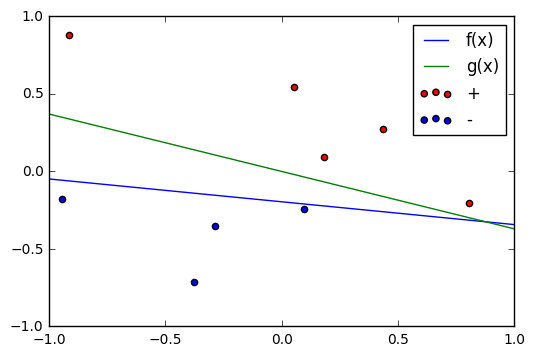

In [180]:
create_plot()

# We need to make a grid to get the area below the line!

In [131]:
def make_grid(num_points = 1001):
    """Creates a grid of points and in the space of [−1, 1] × [−1, 1]
       We will use this to get the area of the negative regions of f(x) and g(x)
    
       Args:
       num_points: represents the refinement of the grid
                   more points ->  more precise area calculation
                   
       returns: N X 2 array representing the space of the graph
    """
    
    line = np.linspace(-1, 1, 1001)
    grid = np.zeros((num_points, num_points, 2))
    for i in np.arange(num_points):
        for j in np.arange(num_points):
            grid[i,j] = np.array((line[i], line[j]))
    
    return grid.reshape(-1,2)

# Now we use that grid to calculate the area under f(x) and g(x)
# We then take the difference!

In [130]:
def get_disagreement(weights_fx, weights_gx, grid):
    """ Calculates P[f(x) != g(x)] by taking the absolute difference
        of the areas of the negative region (doesn't matter which region you take)
        
        Args:         
        weights_fx:  tuple representing (intercept, slope) of f(x)
        weights_gx:  tuple representing (intercept, slope) of g(x)
        grid: N X 2 array representing the space of the graph

        returns: number between 0 and 1 representing probability 
        """
    
    total_points = grid.shape[0]
    
    area_fx = (((grid[:, 1] - grid[:, 0] * weights_fx[1] - weights_fx[0]) <= 0) # sum of points in negative
               .sum() / total_points)                                           # region divided by total points
    
    area_gx = (((grid[:, 1] - grid[:, 0] * weights_gx[1] - weights_gx[0]) <= 0)
               .sum() / total_points)
    
    return abs(area_fx - area_gx) 

# Now we create a function that combines all the previous functions
# And runs them multiple times to get an average disagreement.

In [181]:
def experiment(N=10, trials = 1000):
    """ Calculates PLA algorithm multiple times and gets
        the average of:
            1) the number of iterations needed for convergence
            2) Average P[f(x) != g(x)]

        args: 
        N: number of data points
        trials: number of trials that are averaged 
        """
    
    iters = np.zeros(trials)
    errors = np.zeros(trials)
    grid = make_grid()
    for trial in range(trials):
        two_random_points_for_line = np.random.uniform(-1, 1, (2, 2))
        w_fx = make_weights_for_fx(two_random_points_for_line)
        X, Y = create_random_points_and_labels(N, w_fx)
        w_gx = make_weights_for_gx(X, Y)
        iters[trial] = w_gx[2]
        errors[trial] = get_disagreement(w_fx, w_gx, grid)
    
    avg_iters = iters.mean()
    disagreement = errors.mean()
        
    print("It takes {0} iterations  on average for the PLA " \
          "to converge for N = {1} training points".format(int(avg_iters), N))
    
    print("P[f(x) != g(x)] is appx {0} for N = {1}".format(round(disagreement, 3), N))

# For N=10 points it takes appx:
# 1) 10 iterations for convergence
# 2) P[f(x) $\neq$ g(x)] = 0.14

In [182]:
experiment(N=10)

It takes 10 iterations  on average for the PLA to converge for N = 10 training points
P[f(x) != g(x)] is appx 0.14 for N = 10


# For N=100 points it takes appx:
# 1) 149 iterations for convergence
# 2) P[f(x) $\neq$ g(x)] = 0.019

In [183]:
experiment(N=100)

It takes 149 iterations  on average for the PLA to converge for N = 100 training points
P[f(x) != g(x)] is appx 0.019 for N = 100
